In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [72]:
# resid_df = pd.read_csv('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/full-run_0-ft/reports/residuals/best_resids/63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_best_resids_R2_0.1986_all.csv')
resid_df = pd.read_csv('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all_0-ft/reports/residuals/best_resids/63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_best_resids_R2_0.2127_all.csv')
resid_df = resid_df[~resid_df['dupe']]
def get_triplicated_data_for_time_alignment(df, alignment_col):
    """

    """

    rel_points = df[df[alignment_col] > 0].reset_index()
    identifiers = rel_points[['index', 'nTrial', 'nEndTrial']].dropna().values.astype(int)
    if len(identifiers) == 0:
        return pd.DataFrame(columns=df.reset_index().columns)

    lst_extendeds = []
    
    for idx, nTrial, nEndTrial in identifiers:
        extended_trial = df[(df['nTrial'] == nTrial) | (df['nEndTrial'] == nEndTrial)].reset_index().copy()
        extended_trial = extended_trial[(extended_trial['nTrial'] - extended_trial['nEndTrial']) == extended_trial['diffTrialNums']]
        extended_trial['index'] -= idx

        lst_extendeds.append(extended_trial.copy())
        
    relative_df = pd.concat(lst_extendeds)
    return relative_df

def plot_single_avg_reconstruction_v2(df, alignment_col, channel,
                                      title=None, trial_num=None, x_label=None, y_label=None,
                                      inx_bounds=(-40, 60), signal_bounds=(-1, 2.5),
                                      ic=None, color_lst=['b', 'g', 'y', 'k'],
                                      fig=None, ax=None, show_pred=True):
    """
    
    """

    color = color_lst[ic]
    
    relative_df = get_triplicated_data_for_time_alignment(df, alignment_col)

    df_filt_to_bounds = relative_df[relative_df['index'].between(*inx_bounds)].copy()
    df_filt_to_bounds['resids'] = df_filt_to_bounds[channel] - df_filt_to_bounds['pred']
    num_trials = (df_filt_to_bounds['index'] == 0).sum()

    rmse = np.sqrt((df_filt_to_bounds['resids']**2).mean())

    alignment_name = alignment_col.split('_')[-1]
    sns.lineplot(x='index', y=channel, data=df_filt_to_bounds, label=f'{alignment_col} — {channel} — True', ax=ax, color=color)
    if show_pred:
        sns.lineplot(x='index', y='pred', data=df_filt_to_bounds, label=f'{alignment_col} — {channel} — Pred', ax=ax, color='r')
    
    ax.title.set_text(f'{title} — {num_trials} Trials — RMSE: {rmse:.2f}')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.set_ylim(*signal_bounds)
    ax.grid(visible=True)
    
    return

In [98]:
b0 = np.arange(len(resid_df))
display(b0)

rdc = []

lb = -40
ub = 100
for event_col in ['photometrySideInIndexr']:
    resid_df_cutdown = resid_df[['Unnamed: 0', 'file_num', 'nTrial', 'nEndTrial', 'wi_trial_keep',
                                 'gDA', 'gACH', 'rDA', event_col, 'pred_paramsNum=0_gACH']].copy()

    event = np.where(resid_df_cutdown[event_col].values == 1)[0]
    print(b0.shape, event.shape)
    for iev, ev in enumerate(event):
        delta = b0 - ev
        # print(delta)
        keep_eg = (delta >= -40)&(delta <= 100)
        delta_keep_eg = delta[keep_eg]
        rdf_tmp = resid_df_cutdown.loc[keep_eg].copy()
        rdf_tmp['delta'] = delta_keep_eg
        # display(rdf_tmp)
        # display(list(rdf_tmp.columns))
        rdc.append(rdf_tmp)
        if iev > 10000:
            break
    break

rdc_df = pd.concat(rdc)#.groupby('delta').agg([np.mean, np.std, np.size])

array([      0,       1,       2, ..., 1992474, 1992475, 1992476])

(1992477,) (13011,)


In [99]:
seed = np.random.randint(1000000000)

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/josh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='delta', ylabel='gACH'>

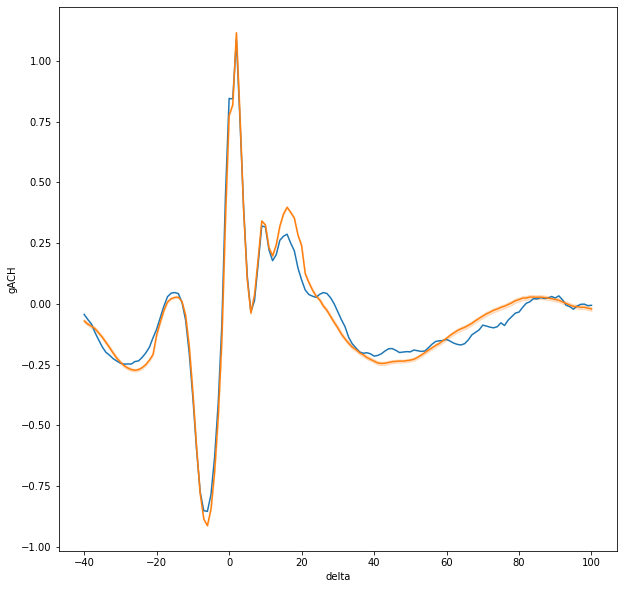

In [100]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(rdc_df['delta'], rdc_df['gACH'], seed=seed, ax=ax)
sns.lineplot(rdc_df['delta'], rdc_df['pred_paramsNum=0_gACH'], seed=seed, ax=ax)

In [101]:
# rdc_df.columns = ['_'.join(_) for _ in rdc_df.columns]
# rdc_df
# col_to_use = 'gACH'
# pred_col_to_use = f'pred_paramsNum=0_{col_to_use}'

# rdc_df[f'lb_{col_to_use}'] = rdc_df[f'{col_to_use}_mean'] - 2*rdc_df[f'{col_to_use}_std']/np.sqrt(rdc_df[f'{col_to_use}_size'])
# rdc_df[f'ub_{col_to_use}'] = rdc_df[f'{col_to_use}_mean'] + 2*rdc_df[f'{col_to_use}_std']/np.sqrt(rdc_df[f'{col_to_use}_size'])

# rdc_df[f'lb_{pred_col_to_use}'] = rdc_df[f'{pred_col_to_use}_mean'] - 2*rdc_df[f'{pred_col_to_use}_std']/np.sqrt(rdc_df[f'{pred_col_to_use}_size'])
# rdc_df[f'ub_{pred_col_to_use}'] = rdc_df[f'{pred_col_to_use}_mean'] + 2*rdc_df[f'{pred_col_to_use}_std']/np.sqrt(rdc_df[f'{pred_col_to_use}_size'])

# # display(rdc_df['gDA_mean'] - 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))
# # display(rdc_df['gDA_mean'] + 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))

# # display(rdc_df['gDA_mean'] - 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))
# # display(rdc_df['gDA_mean'] + 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))

# rdc_df[[f'lb_{col_to_use}', f'{col_to_use}_mean', f'ub_{col_to_use}',
#         f'lb_{pred_col_to_use}', f'{pred_col_to_use}_mean', f'ub_{pred_col_to_use}', 
#         ]].plot()


In [65]:
import glob

coef_dfs = []
# for run_file in glob.glob('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all-10x-h_*/reports/coeffs/best_coeffs/*'):
for run_file in glob.glob(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\fig1\all\oall-nTfn3_*-ft\reports\coeffs\best_coeffs\*.csv'):
    coef_dfs.append(pd.read_csv(run_file))

concat = pd.concat(coef_dfs)
concat = concat.sort_values('channel_name')

In [66]:
concat['channel'] = concat['channel_name'].str.split('_').apply(lambda x: x[0])
concat['channel_num'] = concat['channel_name'].str.split('_').apply(lambda x: x[1])
concat['run_num'] = concat['channel_name'].str.split('_').apply(lambda x: x[-1])
# concat = concat.sort_values([['channel', 'name', 'run_num']])


C:\Users\Josh\AppData\Local\Temp\ipykernel_16388\3271080404.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat['channel'] = concat['channel_name'].str.split('_').apply(lambda x: x[0])
C:\Users\Josh\AppData\Local\Temp\ipykernel_16388\3271080404.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat['channel_num'] = concat['channel_name'].str.split('_').apply(lambda x: x[1])
C:\Users\Josh\AppData\Local\Temp\ipykernel_16388\3271080404.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

In [67]:
concat

,Unnamed: 0,mouse_id,channel_name,name,mse_tr,mse_cv,mse_te,r2_tr,r2_cv,r2_te,...,photometrySideInIndexab_14,photometrySideInIndexab_15,photometrySideInIndexab_16,photometrySideInIndexab_17,photometrySideInIndexab_18,photometrySideInIndexab_19,photometrySideInIndexab_20,channel,channel_num,run_num
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=0,dfresids_cols,0.773607,0.775606,0.774079,0.208677,0.207366,0.204206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,0,num=0
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=1,X_cols_basis,0.771095,0.773155,0.785506,0.209360,0.209268,0.201116,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,0,num=1
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=2,X_cols_basis,0.771523,0.771510,0.783492,0.208498,0.206639,0.205053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,0,num=2
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=3,X_cols_basis,0.774710,0.774247,0.769110,0.206725,0.206787,0.212988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,0,num=3
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=4,all_coeff_dfs,0.773882,0.776719,0.772731,0.207866,0.205769,0.207969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,0,num=4
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=5,_i5,0.773823,0.772554,0.773101,0.208885,0.207707,0.203287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,0,num=5
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=6,_i5,0.773174,0.775938,0.776074,0.207859,0.206292,0.207790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,0,num=6
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_1_run_num=0,dfresids_cols,0.775495,0.776349,0.775838,0.206745,0.207934,0.202397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,1,num=0
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_1_run_num=1,X_cols_basis,0.773021,0.774764,0.787110,0.207386,0.206806,0.199484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,1,num=1
0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_g...,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_1_run_num=2,X_cols_basis,0.773367,0.773396,0.785454,0.206607,0.206051,0.203062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gACH,1,num=2


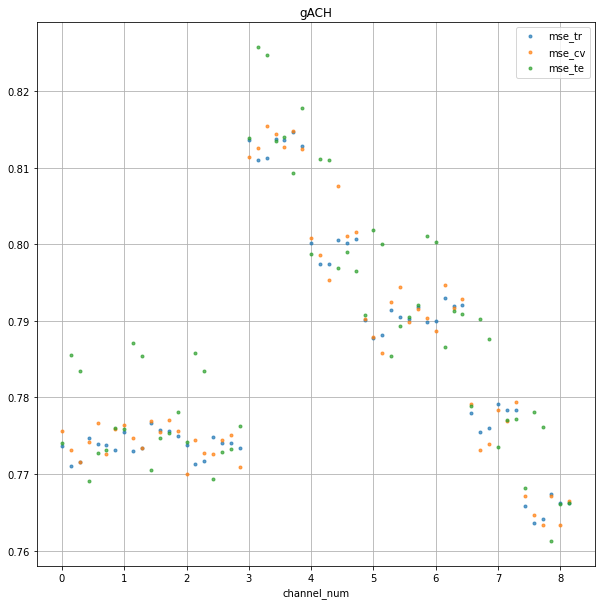

In [68]:
# coef_ci = concat.sort_values('channel_name').groupby('name')[
#     ['mse_tr', 'mse_cv', 'mse_te', 
#     #'r2_tr', 'r2_cv', 'r2_te'
#     ]
# ].agg([np.min, np.max, np.mean, #np.std, np.size
#     ])
# coef_ci.columns = ['_'.join(_) for _ in coef_ci.columns]
for group, group_df in concat.groupby(['channel']):
    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    # display(group_df)
    if type(group) == list:
        title = '_'.join(group)
    else:
        title = group
    group_df.set_index(['channel_num'])[['mse_tr', 'mse_cv', 'mse_te']].plot(marker='.', linestyle='', alpha=0.7, title=title, ax=ax)
    ax.set_xticks([_ for _ in range(len(group_df)) if _%7 == 0])
    ax.set_xticklabels(group_df['channel_num'].iloc[[_ for _ in range(len(group_df)) if _%7 == 0]])
    ax.grid(True)

In [69]:
concat2 = concat.copy()
concat2['mse_dif'] = (concat2['mse_tr'] <= concat2['mse_te'])
concat2['mse_del'] = (concat2['mse_te'] - concat2['mse_tr'])
concat2['r2_dif'] = (concat2['r2_tr'] > concat2['r2_te'])
concat2['r2_del'] = (concat2['r2_tr'] - concat2['r2_te'])
concat2_out = np.round(concat2.groupby(['channel', 'channel_num'])[['mse_dif', 'r2_dif']].agg([np.sum, np.size, np.mean]), 4)
display(concat2_out)
concat2_out = np.round(concat2.groupby(['channel', 'channel_num'])[['mse_del', 'r2_del']].agg([np.mean, np.max, np.min]), 4)
display(concat2_out)

mse_dif              r2_dif             
                        sum size    mean    sum size    mean
channel channel_num                                         
gACH    0                 4    7  0.5714      5    7  0.7143
        1                 4    7  0.5714      6    7  0.8571
        2                 4    7  0.5714      4    7  0.5714
        3                 5    7  0.7143      6    7  0.8571
        4                 2    6  0.3333      4    6  0.6667
        5                 4    6  0.6667      4    6  0.6667
        6                 3    6  0.5000      5    6  0.8333
        7                 3    6  0.5000      4    6  0.6667
        8                 3    6  0.5000      5    6  0.8333

mse_del                  r2_del                
                       mean    amax    amin    mean    amax    amin
channel channel_num                                                
gACH    0            0.0032  0.0144 -0.0056  0.0022  0.0082 -0.0063
        1            0.0032  0.0141 -0.0061  0.0022  0.0079 -0.0068
        2            0.0031  0.0145 -0.0055  0.0022  0.0084 -0.0062
        3            0.0040  0.0147 -0.0054  0.0030  0.0082 -0.0009
        4            0.0028  0.0136 -0.0042  0.0021  0.0072 -0.0043
        5            0.0033  0.0142 -0.0059  0.0026  0.0079 -0.0066
        6            0.0022  0.0112 -0.0064  0.0015  0.0052 -0.0071
        7            0.0032  0.0148 -0.0056  0.0026  0.0086 -0.0063
        8            0.0037  0.0144 -0.0061  0.0031  0.0083 -0.0068

In [102]:
# delta

In [72]:
list(concat2.columns)

['Unnamed: 0',
 'mouse_id',
 'channel_name',
 'name',
 'mse_tr',
 'mse_cv',
 'mse_te',
 'r2_tr',
 'r2_cv',
 'r2_te',
 'timestamp',
 'int',
 'photometryCenterInIndex_-20',
 'photometryCenterInIndex_-19',
 'photometryCenterInIndex_-18',
 'photometryCenterInIndex_-17',
 'photometryCenterInIndex_-16',
 'photometryCenterInIndex_-15',
 'photometryCenterInIndex_-14',
 'photometryCenterInIndex_-13',
 'photometryCenterInIndex_-12',
 'photometryCenterInIndex_-11',
 'photometryCenterInIndex_-10',
 'photometryCenterInIndex_-9',
 'photometryCenterInIndex_-8',
 'photometryCenterInIndex_-7',
 'photometryCenterInIndex_-6',
 'photometryCenterInIndex_-5',
 'photometryCenterInIndex_-4',
 'photometryCenterInIndex_-3',
 'photometryCenterInIndex_-2',
 'photometryCenterInIndex_-1',
 'photometryCenterInIndex_0',
 'photometryCenterInIndex_1',
 'photometryCenterInIndex_2',
 'photometryCenterInIndex_3',
 'photometryCenterInIndex_4',
 'photometryCenterInIndex_5',
 'photometryCenterInIndex_6',
 'photometryCenterIn